In [27]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import numpy.linalg as la
from PIL import Image

def perc_high(a):
    return np.percentile(a,q=90)

def perc_low(a):
    return np.percentile(a,q=10)

def load_fitness(filename):
    ids = []
    fits = []
    parents = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            ids.append(float(row[0]))
            fits.append(float(row[-2]))
            parents.append(int(row[1]))
    return ids, fits, parents

def find_index(_id,ids):
    for i in range(len(ids)):
        if(ids[i] == _id):
            return i

def compute_gen_rec(par_id,ids,parents):
    if(par_id == -1):
        return 0
    for i, id in zip(range(len(ids)),ids):
        if(par_id == id):
            return compute_gen_rec(parents[i],ids,parents) + 1

def compute_generation(ids,parents):
    generation = [0 for _ in range(len(ids))]
    for i in range(len(ids)):
        generation[i] = compute_gen_rec(parents[i],ids,parents)
    return generation

def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(row[0]=='0 0 0 0'):
                continue
            elif(state == 1):
                state = 2
            elif(state == 2):
                nbr_param = int(row[0])
                state = 3
            elif(state == 3):
                nbr_param += int(row[0])
                state = 4
            elif(state == 4 and i < nbr_param):
                i+=1
            elif(state == 4 and i >= nbr_param):
                if(coord[1] == 0):
                    lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])

def compute_lineage_rec(ids,par_id,parents):
    if(par_id == -1):
        return []
    for i, _id in zip(range(len(ids)),ids):
        if(par_id == _id):
            return [_id] + compute_lineage_rec(ids,parents[i],parents)
def compute_lineage(ids,parents):
    lineages = dict()
    for i, _id in zip(range(len(ids)),ids):
        lineages[_id] = compute_lineage_rec(ids,parents[i],parents)
    return lineages

def load_trajectory(filename):
    traj = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=';')
        t = 0
        for row in csv_data:
            position = row[0].split(',')
            pos = [float(elt) for elt in position]
            traj.append([t] + pos)
            t+=1
    return traj

def compute_runtime(filename,nbr_eval):
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        i = 0
        start_time = 0
        end_time = 0
        for row in csv_data:
            if(i==0):
                start_time = float(row[1])
            if(row[0] == "overhead"):
                continue
            if(i==nbr_eval):
                end_time = float(row[2])
            i+=1
    return end_time - start_time

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

In [7]:
desc_lines = []
organ_lines = []
exp_folder = "/home/leni/are-logs/mnipes_v2_multitarget_08_22/selection/"
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/morph_descriptors.csv")
    for desc in descriptors:
        desc_lines.append([desc[0],desc[5]*16,desc[6]*16,desc[7]*16])
wheels = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]
joints = [0 for _ in range(16)]

total=0
for desc in desc_lines:
        wheels[int(desc[1])]+=1
        sensors[int(desc[2])]+=1
        joints[int(desc[3])]+=1

        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    sensors[i]=sensors[i]/total*100
    joints[i]=joints[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","multitarget - arena"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","multitarget - arena"])
for i,s in zip(range(len(joints)),joints):
    organ_lines.append([str(i),s,"joints","multitarget - arena"])

<Figure size 360x360 with 0 Axes>

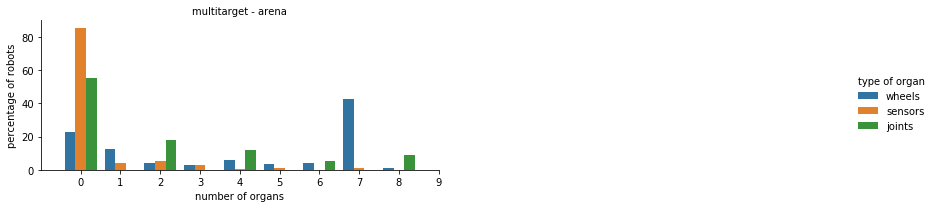

In [8]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 9)))

In [28]:
exp_folder = "/home/leni/are-logs/mnipes_v2_multitarget_08_22/selection/"
list_data = []
for folder in os.listdir(exp_folder):
    list_data.append(load_controller_archive(exp_folder + "/" + folder + "/controller_archive"))

    number of wheels  number of joints  number of sensors   fitness
0                  1                 0                  0  0.707195
1                  1                 0                  3  0.645650
2                  2                 0                  0  0.637623
3                  2                 0                  3  0.639909
4                  3                 0                  3  0.662740
..               ...               ...                ...       ...
82                 4                 0                  0  0.694651
83                 5                 0                  0  0.673771
84                 6                 0                  0  0.707183
85                 7                 0                  0  0.733825
86                 8                 0                  0  0.657801

[87 rows x 4 columns]


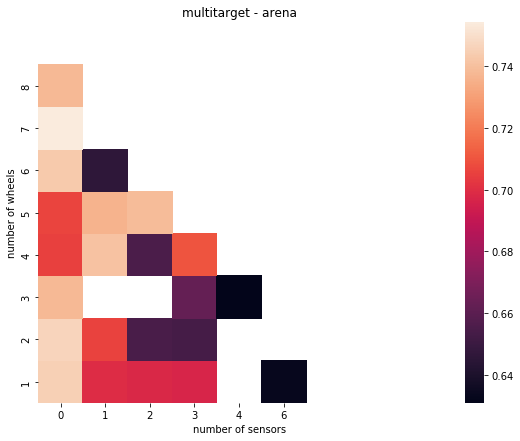

In [35]:
data = pd.concat(list_data,ignore_index=True)
print(data)
data.pop("number of joints")
data = data.groupby(["number of wheels","number of sensors"]).max().squeeze().unstack()
#data = data.pivot(index="number of wheels",columns="number of sensors",values="fitness")
fig = plt.gcf()
fig.set_size_inches(9, 7)
ax = sns.heatmap(data,robust=True)#,vmin=0,vmax=0.2)
ax.set_ylim([0,9])
ax.set_xlim([0,9])
ax.set_title("multitarget - arena")
plt.show()

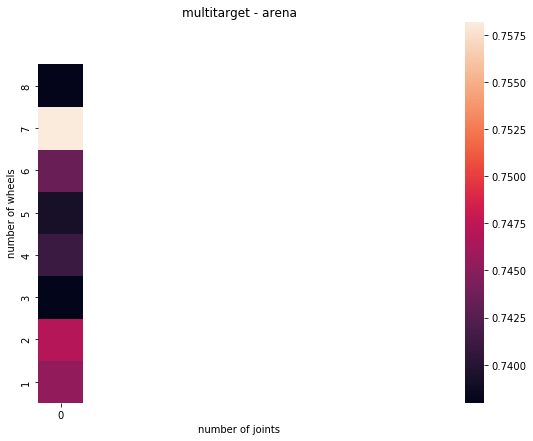

In [33]:
data = pd.concat(list_data,ignore_index=True)
data.pop("number of sensors")
data = data.groupby(["number of wheels","number of joints"]).max().squeeze().unstack()
#data = data.pivot(index="number of wheels",columns="number of sensors",values="fitness")
fig = plt.gcf()
fig.set_size_inches(9, 7)
ax = sns.heatmap(data,robust=True)#,vmin=0,vmax=0.2)
ax.set_ylim([0,9])
ax.set_xlim([0,9])
ax.set_title("multitarget - arena")
plt.show()

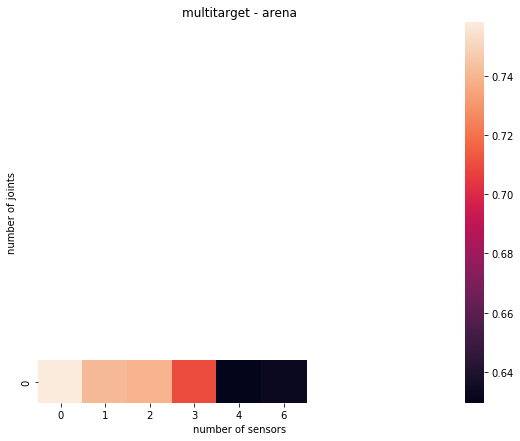

In [34]:
data = pd.concat(list_data,ignore_index=True)
data.pop("number of wheels")
data = data.groupby(["number of joints","number of sensors"]).max().squeeze().unstack()
#data = data.pivot(index="number of wheels",columns="number of sensors",values="fitness")
fig = plt.gcf()
fig.set_size_inches(9, 7)
ax = sns.heatmap(data,robust=True)#,vmin=0,vmax=0.2)
ax.set_ylim([0,9])
ax.set_xlim([0,9])
ax.set_title("multitarget - arena")
plt.show()

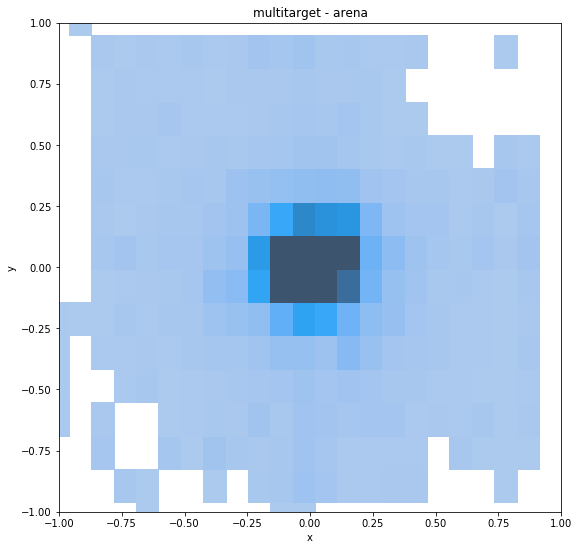

In [24]:
exp_folder = "/home/leni/are-logs/mnipes_v2_multitarget_08_22/selection/"
trajectory = []
for folder in os.listdir(exp_folder):
    for file in os.listdir(exp_folder + "/" + folder):
        if(file.split("_")[0] != "traj"):
            continue
        trajectory += load_trajectory(exp_folder + "/" + folder + "/" + file)

data = pd.DataFrame(data=trajectory,columns=["t","x","y","z"])
fig = plt.gcf()
fig.set_size_inches(9, 9)
ax = sns.histplot(data=data,x="x",y="y",bins=2048,legend=False,pmax=0.3)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_title("multitarget - arena")
plt.show()